# ELE-32 - LAB 4 - Comparação Justa
---

In [1]:
# Libraries import
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numba import njit
import networkx as nx
from multiprocessing import Pool, set_start_method
import csv
from scipy import special

# 1. Obtenha um gráfico da probabilidade de erro em função de $E_i/N_0$ comparando os seguintes sistemas:
---

## 1.1 Sistema BPSK não codificado (não precisa ser simulado)
---

In [2]:
# Defining a function to calculate the Q value (statistics)
def q(v: np.ndarray) -> np.ndarray:
    return 0.5 - 0.5 * special.erf(v / np.sqrt(2))

# Defining a function to simulate a BPSK uncodified probability error
def pe_bpsk(Eb_N0_dB: np.ndarray) -> np.ndarray:
    Eb_N0 = 10**(Eb_N0_dB / 10)
    return q(np.sqrt(2 * Eb_N0))

In [3]:
# Example of simulation of BPSK uncodified probability error
Eb_N0_range = np.arange(-1, 15.1, 0.5) 
pe_bpsk_values = pe_bpsk(Eb_N0_range)

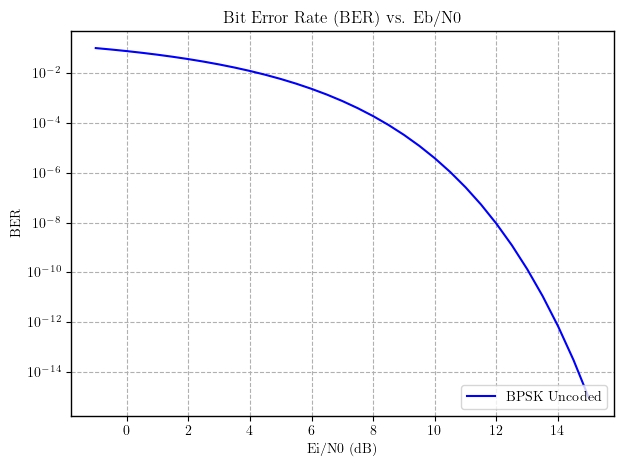

In [4]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(5e-4, 0.11)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [ ]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(pe_bpsk_values, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

## 1.2 Código de Hamming do primeiro laboratório
---

In [5]:
# Defining a function as a Hamming coder
def hamming_coder(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity matrix
    G = np.array([[1, 0, 0, 0, 1, 1, 1],
                  [0, 1, 0, 0, 1, 0, 1],
                  [0, 0, 1, 0, 1, 1, 0],
                  [0, 0, 0, 1, 0, 1, 1]], dtype=int)
    # Encoding the input vector
    output_vector = np.dot(input_vector, G) % 2
    return output_vector

In [6]:
# Define a function for a Binary Symmetric Channel with parameter p
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [7]:
# Define a function for the syndrome calculator
def syndrome(input_vector: np.ndarray) -> np.ndarray:
    # Defining a parity-check matrix
    H = np.array([[1, 1, 1, 0, 1, 0, 0],
                  [1, 0, 1, 1, 0, 1, 0],
                  [1, 1, 0, 1, 0, 0, 1]], dtype=int)
    # Decoding the input vector
    output_vector = np.dot(input_vector, H.T) % 2
    return output_vector

In [8]:
s_dict = {
    '0': (np.array([0, 0, 0]), np.array([0, 0, 0, 0, 0, 0, 0])),
    '1': (np.array([1, 1, 1]), np.array([1, 0, 0, 0, 0, 0, 0])),
    '2': (np.array([1, 0, 1]), np.array([0, 1, 0, 0, 0, 0, 0])),
    '3': (np.array([1, 1, 0]), np.array([0, 0, 1, 0, 0, 0, 0])),
    '4': (np.array([0, 1, 1]), np.array([0, 0, 0, 1, 0, 0, 0])),
    '5': (np.array([1, 0, 0]), np.array([0, 0, 0, 0, 1, 0, 0])),
    '6': (np.array([0, 1, 0]), np.array([0, 0, 0, 0, 0, 1, 0])),
    '7': (np.array([0, 0, 1]), np.array([0, 0, 0, 0, 0, 0, 1]))
}

In [9]:
# Calculating the e_prime from syndrome
def e_prime_calc(s: np.ndarray) -> np.ndarray:
    for s_index in s_dict.items():
        if np.array_equal(s_index[1][0], s):
            return s_index[1][1]

In [10]:
# Defining the Hamming decoder function with 1-bit correction
def hamming_decoder(input_vector: np.ndarray) -> np.ndarray:
    s = syndrome(input_vector)
    e_prime = e_prime_calc(s)
    decoded = (input_vector + e_prime) % 2
    return decoded[:4]

In [11]:
def hamming_pb_est(p: float) -> float:
    sample_size = 5_000
    error_count = 0
    k = 4
    l = int(sample_size/k)

    for _ in range(l):
        input_vector = np.random.randint(0, 2, k)
        input_decoded = hamming_coder(input_vector)
        transmitted_vector = bsc(input_decoded, p)
        decoded_vector = hamming_decoder(transmitted_vector)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return (1/sample_size) * error_count 

In [12]:
K = 4
N = 7

R = K/N

In [13]:
hamming_pb_est(0.1)

0.0746

In [14]:
def hamming_pb_est_parallel(p: float, sample_size: int) -> float:
    error_count = 0
    k = 4

    input_vector = np.random.randint(0, 2, k)
    input_decoded = hamming_coder(input_vector)
    transmitted_vector = bsc(input_decoded, p)
    decoded_vector = hamming_decoder(transmitted_vector)
    error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count

In [15]:
# 1.5 min
def worker(args):
    prob, sample_size = args
    return hamming_pb_est_parallel(prob, sample_size)

if __name__ == "__main__":
    erros_list_hamming = []
    prob_list = [0.5, 0.2, 0.1, 0.05, 
                 0.02, 0.01, 0.005, 0.001, 
                 0.0005, 0.0004, 0.0003, 0.00025, 
                 0.0001, 0.00005, 0.00001, 0.000005, 0.00001]    

    # Create a Pool of processes
    with Pool() as p:
        for prob in prob_list:
            print(f'calculating {prob}')
            # Map the function to the data
            if prob >= 0.001:
                sample_size = 5_000
                l = int(sample_size/4)
                erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(prob, sample_size) for _ in range(l)]))))
                erros_list_hamming.append(np.sum(erros)/sample_size)
            else: 
                sample_size = 10_000
                l = int(sample_size/4)
                erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(prob, sample_size) for _ in range(l)]))))
                erros_list_hamming.append(np.sum(erros)/sample_size)

calculating 0.5


In [ ]:
def q_inv(v: np.ndarray) -> np.ndarray:
    return np.sqrt(2) * special.erfinv(np.ones(len(v)) - np.dot(2, v))

def Ei_N0_dB_BSC_convert(prob_list: np.ndarray, R: float) -> np.ndarray:
    Eb_N0 = ((q_inv(prob_list)) ** 2) / 2
    Ei_N0 = Eb_N0 / R
    return 10 * np.log10(Ei_N0)

In [ ]:
Ei_N0_from_p_hamming = Ei_N0_dB_BSC_convert(prob_list, R)

In [ ]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded", color='red')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(0, 5)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [ ]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(erros_list_hamming, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

## 1.3 Desempenho do código LDPC com $N \approx 1000$ utilizando o algoritmo bit-flipping do segundo laboratório
---

In [ ]:
# Define a function to set the parameters
@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)

In [ ]:
# Define a function for a Binary Symmetric Channel with parameter p
@njit
def bsc(input_vector: np.ndarray, p: float) -> np.ndarray:
    # Generate a random vector with the same length as the input vector
    random_vector = np.random.rand(input_vector.shape[0])
    # Apply the channel to the input vector
    output_vector = (input_vector + (random_vector < p)) % 2
    return output_vector

In [ ]:
def is_peg_matrix(matrix: np.ndarray) -> bool:
    """
    Checa se uma matriz é uma matriz PEG (Progressive Edge Growth).

    Parâmetros:
    - matrix (ndarray): A matriz a ser verificada.

    Retorna:
    - bool: True se a matriz é uma matriz PEG, False caso contrário.
    """
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True

def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC usando o algoritmo PEG (Progressive Edge Growth).

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.
    """
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Exclude nodes that are already connected to j
                connected_nodes = [edge[0] for edge in edges if edge[1] == j]
                candidate_nodes = np.setdiff1d(np.arange(M), np.union1d(tree, connected_nodes))

                if len(candidate_nodes) == 0:
                    # If no candidate nodes are available, skip this edge
                    continue

                min_degree = np.min(check_degrees[candidate_nodes])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    for edge in edges:
        H[edge[0], edge[1]] = 1

    if is_peg_matrix(H):
        return H
    else:
        return generate_LDPC_matrix_PEG(N, dv, dc, K, M)

In [ ]:
# Define a function for the parity check matrix
@njit
def parity_check(H: np.array, y: np.array) -> np.array:
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * y) % 2
    
    return s

# Define a function for the bit-flipping algorithm to decode the message
@njit
def bit_flipping(H: np.array, y: np.array, max_iter: int) -> np.array:
    iteration = 0
    x = y.copy()
    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = parity_check(H, x)

    while np.sum(s) != 0 and iteration <= max_iter:
        for i in range(column_length):
            errors[i] = np.sum(H[:, i] * s)

        for i in range(len(errors)):
            if errors[i] == np.max(errors):
                x[i] ^= 1    

        s = parity_check(H, x)
        iteration += 1

    return x

In [ ]:
N = 1001
dv = 3
dc = 7
K, M = set_params(N, dv, dc)
LDPC_matrix_PEG = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
R = K/M

In [ ]:
@njit
def ham_bit_flip_pb_est(p: float, N: int) -> float:
    sample_size = 10_000.
    error_count = 0.
    k = N
    l = int(sample_size/k)
    num_of_bits = l * k

    for _ in range(l):
        input_vector = np.zeros(k, dtype = np.int32)        
        output_vector = bsc(input_vector, p)
        decoded_vector = bit_flipping(LDPC_matrix_PEG, output_vector, 10)
        error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count/num_of_bits

In [ ]:
a = ham_bit_flip_pb_est(0.02, N)
a

In [ ]:
@njit
def ham_bit_flip_pb_est_parallel(p: float, N: int) -> float:
    error_count = 0.
    k = N

    input_vector = np.zeros(k, dtype = np.int32)        
    output_vector = bsc(input_vector, p)
    decoded_vector = bit_flipping(LDPC_matrix_PEG, output_vector, 10)
    error_count += np.count_nonzero(input_vector != decoded_vector)

    return error_count

In [ ]:
def worker(args):
    prob, N = args
    return ham_bit_flip_pb_est(prob, N)

if __name__ == "__main__":
    erros_list = []
    prob_list = [0.5, 0.2, 0.1, 0.05, 
                 0.02, 0.01, 0.005, 0.001, 
                 0.0005, 0.0004, 0.0003, 0.00025, 
                 0.0001, 0.00005, 0.00001, 0.000005, 0.00001]
    #sample_size = 100_000
    #l = int(sample_size/4)
    #num_of_bits = l * N

    # Create a Pool of processes
    with Pool() as p:
        #for prob in prob_list:
            # Map the function to the data
            erros_list_bit_flip = np.array(p.map(worker, [(prob, N) for prob in prob_list]))
            #erros_list.append(np.sum(erros)/num_of_bits)

In [ ]:
a, erros

In [ ]:
Ei_N0_from_p_bit_flip = Ei_N0_dB_BSC_convert(prob_list, R)

In [ ]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (429/1001)", color='black')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(0, 5)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 4)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [ ]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(erros_list_bit_flip, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

## 1.4 Desempenho do código LDPC com N $\approx$ 1000 utilizando o algoritmo que usa LLRs do terceiro laboratório
---

In [ ]:
@njit
def calcular_variancia_ruido(Eb_N0_dB: float) -> float:
    """
    Calcula a variância do ruído com base na relação sinal-ruído Eb/N0 em decibéis.

    Args:
        Eb_N0_dB (float): A relação sinal-ruído Eb/N0 em decibéis.

    Returns:
        float: A variância do ruído.

    """
    # Converter a relação sinal-ruído Eb/N0 de decibéis para linear
    Eb_N0 = 10**(Eb_N0_dB / 10)

    # Calcular a densidade espectral de potência do ruído
    N0 = 1 / Eb_N0

    # Calcular a variância do ruído
    sigma2 = N0 / 2

    return sigma2

@njit 
def gerar_simbolos_bpsk_zero(num_bits: int) -> np.ndarray:
    """
    Gera símbolos BPSK com todos os bits iguais a zero.

    Parâmetros:
    - num_bits: O número de bits a serem gerados.

    Retorna:
    - Uma sequência de símbolos BPSK com todos os bits iguais a zero.
    """
    return np.full(num_bits, 1)

@njit
def calcular_valor_recebido(simbolos: np.ndarray, Eb_N0_dB: float) -> np.ndarray:
    """
    Calcula o valor recebido adicionando ruído gaussiano aos símbolos transmitidos.

    Parâmetros:
    simbolos (array): Array contendo os símbolos transmitidos.
    Eb_N0_dB (float): Relação sinal-ruído em dB.

    Retorna:
    array: Array contendo os símbolos recebidos após a adição de ruído gaussiano.
    """
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    sigma = np.sqrt(sigma2)
    ruido = sigma * np.random.randn(len(simbolos))
    r = simbolos + ruido
    return r

@njit
def calcular_valores_llr(r: np.ndarray, sigma2: float) -> np.ndarray:
    """
    Calcula os valores do Log-Likelihood Ratio (LLR) para uma sequência de bits recebida.

    Args:
        r (float): A sequência de bits recebida.
        sigma2 (float): A variância do ruído.

    Returns:
        float: Os valores do LLR para cada bit da sequência recebida.
    """
    llr = 2 * r / sigma2
    return llr

# Define a function for the parity check matrix
@njit
def syndrome_calc(H: np.array, x: np.array) -> np.array:
    """
    Calcula o vetor de síndrome de um código LDPC.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - x: O vetor de bits a ser verificado.

    Retorna:
    - Um vetor de síndrome.
    """
    s = np.zeros(H.shape[0], dtype = np.int32)

    for i in range(len(H)):
        s[i] = np.sum(H[i] * x) % 2
    
    return s

@njit
def parity_check(H: np.array, y: np.array) -> bool:
    """
    Verifica se um vetor y é um código válido de um código LDPC.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - y: O vetor de bits a ser verificado.

    Retorna:
    - Um valor booleano indicando se o vetor y é um código válido.
    """
    x = y.copy()
    for i in range(len(y)):
        if x[i] > 0:
            x[i] = 0
        else:
            x[i] = 1

    column_length = H.shape[1]
    errors = np.ones(column_length, dtype = np.int32)

    s = syndrome_calc(H, x)
    
    for i in range(column_length):
        errors[i] = np.sum(H[:, i] * s)

    if np.sum(errors) == 0:
        return True
    else:
        return False

@njit
def set_params(N: int, dv: int, dc: int) -> tuple[int, int]:
    """
    Define os parâmetros do código LDPC.

    Args:
        N (int): O tamanho do código.
        dv (int): O grau do vetor de checagem.
        dc (int): O grau do vetor de informação.

    Returns:
        tuple[int, int]: Uma tupla contendo o tamanho da mensagem (K) e o tamanho do código (M).
    
    Raises:
        ValueError: Se N não for divisível por dc.
    """
    if (N  % dc != 0):
        raise ValueError("N must be divisible by dc")
    else:
        K = int(N / dc)
        M = int(K * dv)
        return (K, M)
    
def is_peg_matrix(matrix: np.ndarray) -> bool:
    """
    Checa se uma matriz é uma matriz PEG (Progressive Edge Growth).

    Parâmetros:
    - matrix (ndarray): A matriz a ser verificada.

    Retorna:
    - bool: True se a matriz é uma matriz PEG, False caso contrário.
    """
    # Check if the matrix is binary
    if not np.array_equal(matrix, matrix.astype(bool)):
        return False

    # Check if the matrix is sparse
    if np.count_nonzero(matrix) / matrix.size > 0.5:
        return False

    # Check if the matrix is regular
    row_counts = np.count_nonzero(matrix, axis=1)
    if np.any(row_counts != row_counts[0]):
        return False
    col_counts = np.count_nonzero(matrix, axis=0)
    if np.any(col_counts != col_counts[0]):
        return False

    return True

def generate_LDPC_matrix_PEG(N: int, dv: int, dc: int, K: int, M: int) -> np.ndarray:
    """
    Gera uma matriz LDPC usando o algoritmo PEG (Progressive Edge Growth).

    Parâmetros:
    - N (int): O número total de colunas da matriz.
    - dv (int): O grau do vértice variável.
    - dc (int): O grau do vértice de checagem.
    - K (int): O número de linhas da matriz antes da expansão.
    - M (int): O número de vezes que a matriz é expandida.

    Retorna:
    - H (ndarray): A matriz LDPC gerada.
    """
    H = np.zeros((M, N), dtype=np.int32)
    check_degrees = np.zeros(M, dtype=np.int32)
    symbol_degrees = np.zeros(N, dtype=np.int32)
    edges = []

    for j in range(N):
        for k in range(dv):
            if k == 0:
                min_degree = np.min(check_degrees)
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1
            else:
                tree = [j]
                for l in range(1, dc + 1):
                    next_level = []
                    for node in tree:
                        next_level.extend([edge[1] for edge in edges if edge[0] == node])
                    if len(next_level) == 0 or len(set(next_level)) < M:
                        break
                    tree = next_level

                # Exclude nodes that are already connected to j
                connected_nodes = [edge[0] for edge in edges if edge[1] == j]
                candidate_nodes = np.setdiff1d(np.arange(M), np.union1d(tree, connected_nodes))

                if len(candidate_nodes) == 0:
                    # If no candidate nodes are available, skip this edge
                    continue

                min_degree = np.min(check_degrees[candidate_nodes])
                min_degree_indices = np.where(check_degrees == min_degree)[0]
                ci = np.random.choice(min_degree_indices)
                edges.append((ci, j))
                check_degrees[ci] += 1
                symbol_degrees[j] += 1

    for edge in edges:
        H[edge[0], edge[1]] = 1

    if is_peg_matrix(H):
        return H
    else:
        return generate_LDPC_matrix_PEG(N, dv, dc, K, M)
    
@njit
def inicializar_mensagens(H: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Inicializa as mensagens dos c-nodes para os v-nodes e dos v-nodes para os c-nodes.

    Args:
        H (numpy.ndarray): Matriz de verificação de paridade (H).

    Returns:
        tuple: Uma tupla contendo as mensagens dos c-nodes para os v-nodes (Le) e as mensagens dos v-nodes para os c-nodes (Lr).
    """
    num_cnodes, num_vnodes = H.shape
    Le = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos c-nodes para os v-nodes
    Lr = np.zeros((num_cnodes, num_vnodes))  # Mensagens dos v-nodes para os c-nodes
    return Le, Lr

@njit
def atualizar_mensagens_vnodes(Lr: np.ndarray, Lc: np.ndarray, Le: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós variáveis (v-nodes) de acordo com a matriz de paridade H.

    Parâmetros:
    - Lr: numpy.ndarray, matriz de mensagens nos nós de verificação (r-nodes)
    - Lc: numpy.ndarray, vetor de mensagens nos nós de checagem (c-nodes)
    - Le: numpy.ndarray, matriz de mensagens extrínsecas
    - H: numpy.ndarray, matriz de paridade

    Retorna:
    - Lr: numpy.ndarray, matriz de mensagens atualizadas nos nós de verificação (r-nodes)
    """
    num_cnodes, num_vnodes = H.shape
    for i in range(num_vnodes):
        for j in range(num_cnodes):
            if H[j, i] == 1:
                Lr[j, i] = Lc[i] + np.sum(Le[:, i]) - Le[j, i]
    return Lr

@njit
def atualizar_mensagens_cnodes(Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Atualiza as mensagens nos nós de verificação (cnodes) de acordo com a matriz de paridade H.

    Args:
        Le (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos cnodes.
        Lr (numpy.ndarray): Array bidimensional que representa as mensagens de entrada nos vnodes.
        H (numpy.ndarray): Matriz de paridade que define as conexões entre cnodes e vnodes.

    Returns:
        numpy.ndarray: Array bidimensional com as mensagens atualizadas nos cnodes.
    """
    num_cnodes, num_vnodes = H.shape
    for j in range(num_cnodes):
        for i in range(num_vnodes):
            if H[j, i] == 1:
                # Calcula o produto dos sinais
                product_sign = 1
                min_value = np.inf
                for k in range(num_vnodes):
                    if k != i and H[j, k] == 1:
                        product_sign *= np.sign(Lr[j, k])
                        min_value = min(min_value, abs(Lr[j, k]))
                # Calcula a mensagem de saída usando a equação 11
                Le[j, i] = product_sign * min_value
    return Le

@njit
def iteracao(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray) -> np.ndarray:
    """
    Realiza uma iteração do algoritmo de decodificação LDPC.

    Parâmetros:
    Lc (array): Array contendo as mensagens a priori dos c-nodes.
    Le (array): Array contendo as mensagens a priori dos v-nodes.
    Lr (array): Array contendo as mensagens dos v-nodes para os c-nodes.
    H (array): Matriz de verificação de paridade.

    Retorna:
    decision (array): Array contendo as decisões de bits após a iteração.
    """
    # Atualizar mensagens dos v-nodes
    Lr = atualizar_mensagens_vnodes(Lr, Lc, Le, H)
    
    # Atualizar mensagens dos c-nodes
    Le = atualizar_mensagens_cnodes(Le, Lr, H)
    
    # Critério de parada: verificar se todas as equações de paridade são satisfeitas
    decision = np.sign(Lc + np.sum(Le, axis=0))
    return decision


@njit
def dot_product(H: np.ndarray, decision: np.ndarray) -> np.ndarray:
    """
    Calcula o produto escalar entre a matriz de verificação de paridade e as decisões de bits.

    Parâmetros:
    - H: A matriz de verificação de paridade.
    - decision: As decisões de bits.

    Retorna:
    - Um vetor de bits resultante do produto escalar.
    """
    result = np.zeros(H.shape[0], dtype=H.dtype)
    for i in range(H.shape[0]):
        for j in range(H.shape[1]):
            result[i] += H[i, j] * decision[j]
    return result

@njit
def ldpc_decode(Lc: np.ndarray, Le: np.ndarray, Lr: np.ndarray, H: np.ndarray, max_iter: int = 50) -> np.ndarray:
    """
    Decodifica uma sequência de bits usando o algoritmo LDPC.

    Parâmetros:
    - Lc: array numpy de tamanho N, contendo as log-verossimilhanças dos bits recebidos.
    - H: array numpy de tamanho MxN, contendo a matriz de verificação de paridade LDPC.
    - max_iter: número máximo de iterações do algoritmo (padrão: 100).

    Retorna:
    - decoded_bits: array numpy de tamanho N, contendo os bits decodificados.

    """

    Le, Lr = inicializar_mensagens(H)
    n = 0

    for _ in range(max_iter):
        n += 1
        decision = iteracao(Lc, Le, Lr, H)
        if parity_check(H, decision):
            break
    
    # print(f"{n} iterações")
    # Decisão final
    Lf = Lc + np.sum(Le, axis=0)
    decoded_bits = np.sign(Lf).astype(np.int32)
    return decoded_bits

In [ ]:
# Definindo os parâmetros para simulação
num_bits = 1001
Eb_N0_dB_range = np.arange(-2.5, 15.5, 0.5)

N = num_bits
dv = 3
dc = 7
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
R = K/M
is_peg_matrix(H)

In [ ]:
@njit
def simular_desempenho_ldpc_parallel_iter(H: np.ndarray, num_bits: int, Eb_N0_dB: float) -> float:
    # Gerar símbolos BPSK
    simbolos = gerar_simbolos_bpsk_zero(num_bits).astype(np.float64)
    
    # Calcular valores recebidos com ruído
    r = calcular_valor_recebido(simbolos, Eb_N0_dB)
    
    # Calcular valores LLR
    sigma2 = calcular_variancia_ruido(Eb_N0_dB)
    Lc = calcular_valores_llr(r, sigma2)
    
    # Decodificar
    Le, Lr = inicializar_mensagens(H)
    bits_decodificados = ldpc_decode(Lc, Le, Lr, H, max_iter = 10).astype(np.float64)
        
    return np.count_nonzero(simbolos != bits_decodificados)

@njit
def ber_total(erros: np.ndarray, num_iter: int, num_bits: int) -> float:
    return np.sum(erros) / (num_iter * num_bits)

In [ ]:
@njit
def worker(args):
    H, num_bits, Eb_N0_dB = args
    return simular_desempenho_ldpc_parallel_iter(H, num_bits, Eb_N0_dB)

if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.arange(-2.5, 11, 0.5)  # replace with your actual range
    num_iter =  np.full(shape = len(Eb_N0_dB), fill_value = 1_000)  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        for (Eb, num) in zip(Eb_N0_dB, num_iter):
            erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb) for _ in range(num)]))))
            ber = ber_total(erros, num, num_bits)
            ber_list.append(ber)

In [ ]:
ber_list

In [ ]:
Ei_N0_from_p_ldpc = Ei_N0_dB_BSC_convert(ber_list, R)

In [ ]:
Ei_N0_from_p_ldpc

In [ ]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (429/1001)", color='black')
ax.plot(Ei_N0_from_p_ldpc, ber_list, label=r"LDPC Belief Propagation (429/1001)", color='green')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(0, 5)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 0)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [ ]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_list, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")

## 1.5 Desempenho do código LDPC com N $\approx$ 1000 utilizando o algoritmo próprio
---

In [ ]:
# Definindo os parâmetros para simulação
num_bits = 1002
Eb_N0_dB_range = np.arange(-2, 15.5, 0.5)

N = num_bits
dv = 3
dc = 6
K, M = set_params(N, dv, dc)
H = generate_LDPC_matrix_PEG(N, dv, dc, K, M)
R = K/M
is_peg_matrix(H)

In [ ]:
if __name__ == "__main__":
    ber_list = []
    Eb_N0_dB = np.arange(-2.5, 11, 0.5)  # replace with your actual range
    num_iter =  np.full(shape = len(Eb_N0_dB), fill_value = 1_000)  # replace with your actual value

    # Create a Pool of processes
    with Pool() as p:
        # Map the function to the data
        for (Eb, num) in zip(Eb_N0_dB, num_iter):
            erros = np.array(list(filter(lambda x: x != 0, p.map(worker, [(H, num_bits, Eb) for _ in range(num)]))))
            ber = ber_total(erros, num, num_bits)
            ber_list.append(ber)

In [ ]:
ber_list

In [ ]:
Ei_N0_from_p_ldpc = Ei_N0_dB_BSC_convert(ber_list, R)

In [ ]:
Ei_N0_from_p_ldpc

In [ ]:
# Make a log plot of p vs. the estimated error rate
matplotlib.font_manager._load_fontmanager(try_read_cache=False)
plt.rcParams['font.family'] = "CMU Serif"
plt.rcParams['text.usetex'] = True
plt.rcParams['axes.linewidth'] = 1.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(Eb_N0_range, pe_bpsk_values, label=r"BPSK Uncoded", color='blue')
ax.plot(Ei_N0_from_p_hamming, erros_list_hamming, label=r"Hamming Coded (4/7)", color='red')
ax.plot(Ei_N0_from_p_bit_flip, erros_list_bit_flip, label=r"Bit Flipping (429/1001)", color='black')
ax.plot(Ei_N0_from_p_ldpc, ber_list, label=r"LDPC Belief Propagation (429/1001)", color='green')
ax.plot(Ei_N0_from_p_ldpc, ber_list, label=r"Custom LDPC Belief Propagation (501/1002)", color='brown')
ax.grid(True, which="both", ls="--")
# Set xlims
#ax.set_xlim(0, 5)
#ax.set_ylim(1e-7, 8e-1)
# ax.set_xscale('log')
# horizontal line in y = 10^-4
ax.set_yscale('log')
ax.legend(loc = 0)
ax.set_xlabel('Ei/N0 (dB)')
ax.set_ylabel('BER')
ax.set_title("Bit Error Rate (BER) vs. Eb/N0")
#plt.gca().invert_xaxis()
#plt.savefig('error_rate_estimation3.pdf')
plt.show()

In [ ]:
def encontrar_menor_eb_n0(ber_results, Eb_N0_dB_range, threshold=1e-4):
    for Eb_N0_dB, ber in zip(Eb_N0_dB_range, ber_results):
        if ber < threshold:
            return Eb_N0_dB
    return None

# Encontrar o menor valor de Eb/N0 para BER < 10^-4
menor_eb_n0 = encontrar_menor_eb_n0(ber_list, Eb_N0_dB_range)
print(f"Menor valor de Eb/N0 para BER < 10^-4: {menor_eb_n0} dB")